# Prediccion del resultado de eventos musicales


Se cuenta con un conjunto de 360 eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

Para analizar el problema, se buscó contar con un conjunto de variables independientes, que permitieran caracterizar al evento. En primer lugar, se tomaron datos del evento:
    * estado de EEUU
    * día de la semana
    * capacidad del recinto
    * precio del ticket

Por otro lado, se realizó la recopilación de datos de redes sociales, accediendo a las APIs de las redes, para cada uno de los artistas del conjunto. Se comenzó con la recopilación de las redes (los nombres) para cada artista. Posteriormente, se hizo la captura de datos, de manera automática.

Las redes accedidas fueron:
    * Facebook : likes en la pagina del artista
    * Youtube : suscriptores del canal
    * Instagram : followers, likes
    * Spotify : followers, popularidad
    * Twitter : followers, menciones en USA, menciones mundo

Además, se realizó la captura en días distintos (una semana de diferencia), obteniendo un indicador de crecimiento para algunas de las cifras. Estas son:
    * crecimiento likes de facebook
    * crecimiento followers de instagram
    * crecimiento followers de twitter

El resultado de esto fue la construcción de un vector de 15 componentes, con los datos de las redes sociales (variables independientes) junto a los datos de los eventos.

Este notebook esta organizado de la siguiente manera:
    * carga de datos
    * pruebas con todas las variables
        - asignacion de variables (1)
        - analisis de variables
        - modelo de regresion, con validacion cruzada
    * recursive feature elimination
    * pruebas con algunas variables
        - asignacion de variables (2)
        - prueba de algoritmos, con conjunto de test
        - modelo de regresion, con validacion cruzada

In [1551]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn_pandas as sp
import sys
import copy
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

threshold = 77

In [1552]:
# modelos de regresion

models = {}
models['linearreg']    = LinearRegression()
models['svr']          = SVR(kernel='rbf', C=1.0, gamma='auto', degree=2)
models['knn']          = KNeighborsRegressor()
models['ridge']        = Ridge(alpha=[0.001])
models['lasso']        = Lasso()
models['elasticnet']   = ElasticNet()
models['dectree']      = DecisionTreeRegressor(max_features=0.1, criterion='friedman_mse', random_state=3)
models['randomforest'] = RandomForestRegressor(n_estimators=400, criterion='mse', max_depth=None, min_samples_split=1, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=4, random_state=None, verbose=0)
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor()
models['knn']          = KNeighborsRegressor()

# Pruebas con todas las variables

En primer lugar se realiza la carga de datos, separando los conjuntos de entrenamiento y test, y extrayendo la variable dependiente (values). Se determinó utilizar una separación del conjunto de datos, destinando un 10% de la muestra para test, y el 90% restante para entrenamiento.


In [1826]:
# carga de datos y seleccion de variables

dataset = pd.read_csv('/home/dgomez/rrss_pob_filtrado.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
#dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)

count: 360
mean: 81.125
std: 23.73797159120012


In [1827]:
# seleccion de variables

mapper = sp.DataFrameMapper([
    ('dayofweek', LabelBinarizer()),
    (['state_pob', 'capacity', 'price', 'facebook_likes', 'youtube_suscrs',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['state_pob', 'dayofweek', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['state_pob', 'dayofweek', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets']]
X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe

# Analisis de variables

A continuación se realiza el análisis de las variables, graficando la relación entre cada par de variables. También, se grafica la relación de cada variable con la variable dependiente ("tickets").
<BR>
Este análisis permite revisar el nivel de correlación de cada variable respecto al valor a predecir.

In [1458]:
Xy[0:10]

,state_pob,dayofweek,capacity,price,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
0,6547629,7,953,29.50,10274954,287123737,7300000,536800,3029243,81,12699509,108,27,-0.062,0.000,0.158,100
1,6483802,3,1417,52.50,762373,113736876,122600,43792,161105,59,91464,100,29,0.185,0.571,0.021,98
2,4533372,5,1300,17.50,454703,21199358,219500,21029,93882,60,140624,100,59,0.159,0.137,0.031,40
3,38332521,6,10000,37.50,454703,21199358,219500,21029,93882,60,140624,100,59,0.159,0.137,0.031,100
4,5686986,5,1042,44.50,215616,4005073,90100,4165,1193,14,533143,100,47,0.003,0.333,-0.042,73
5,19378102,4,450,27.50,47495,17292,18200,5627,6255,37,67301,100,11,0.084,0.549,0.260,25
6,2700551,5,244,49.00,31915,90035,1324,377,15020,40,1169,33,3,-0.019,0.378,0.000,100
7,989415,3,1425,31.75,3653615,5309730,1200000,96300,1548813,72,1867218,112,45,-0.060,0.000,-0.068,72
8,2700551,5,3364,39.25,1654182,488910476,273500,52700,163,0,528265,100,11,-0.006,0.402,-0.036,64
9,38332521,2,425,19.00,96103,12140493,65400,28728,148732,62,28223,100,58,0.147,1.225,0.223,100


In [1459]:
Xy.describe().round(decimals=2)

,state_pob,dayofweek,capacity,price,facebook_likes,youtube_suscrs,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,instagram_crec,twitter_crec,tickets
count,360.00,360.00,360.00,360.00,360.00,3.600000e+02,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00
mean,11982324.51,4.60,2601.33,47.88,2581906.56,4.427922e+07,2165355.42,110915.37,614796.46,52.70,1990527.46,456.04,201.39,0.09,0.60,0.25,81.12
std,10006014.20,1.61,4831.86,42.99,6917112.22,1.535232e+08,9260745.56,399477.49,1508460.05,19.27,8537012.86,2502.91,1262.64,0.54,0.88,0.80,23.74
min,601723.00,1.00,100.00,7.10,1563.00,0.000000e+00,258.00,0.00,3.00,0.00,42.00,0.00,0.00,-7.39,-1.17,-2.79,5.00
25%,5303925.00,4.00,468.75,20.00,47044.00,9.840675e+04,11925.00,1862.00,17302.00,42.00,10056.50,97.00,13.50,-0.03,0.09,-0.01,64.00
50%,6724540.00,5.00,1150.00,37.50,260592.50,1.333448e+06,64300.00,10128.50,85286.00,55.00,54237.00,100.00,41.50,0.00,0.36,0.07,92.50
75%,19378102.00,6.00,2498.50,57.25,1751068.25,1.343300e+07,343975.00,35271.00,523637.00,66.00,419010.00,195.00,117.00,0.10,0.84,0.24,100.00
max,38332521.00,7.00,55292.00,478.50,44727137.00,1.640133e+09,75100000.00,4286600.00,9450508.00,94.00,66068104.00,38919.00,22184.00,4.05,9.09,10.34,100.00


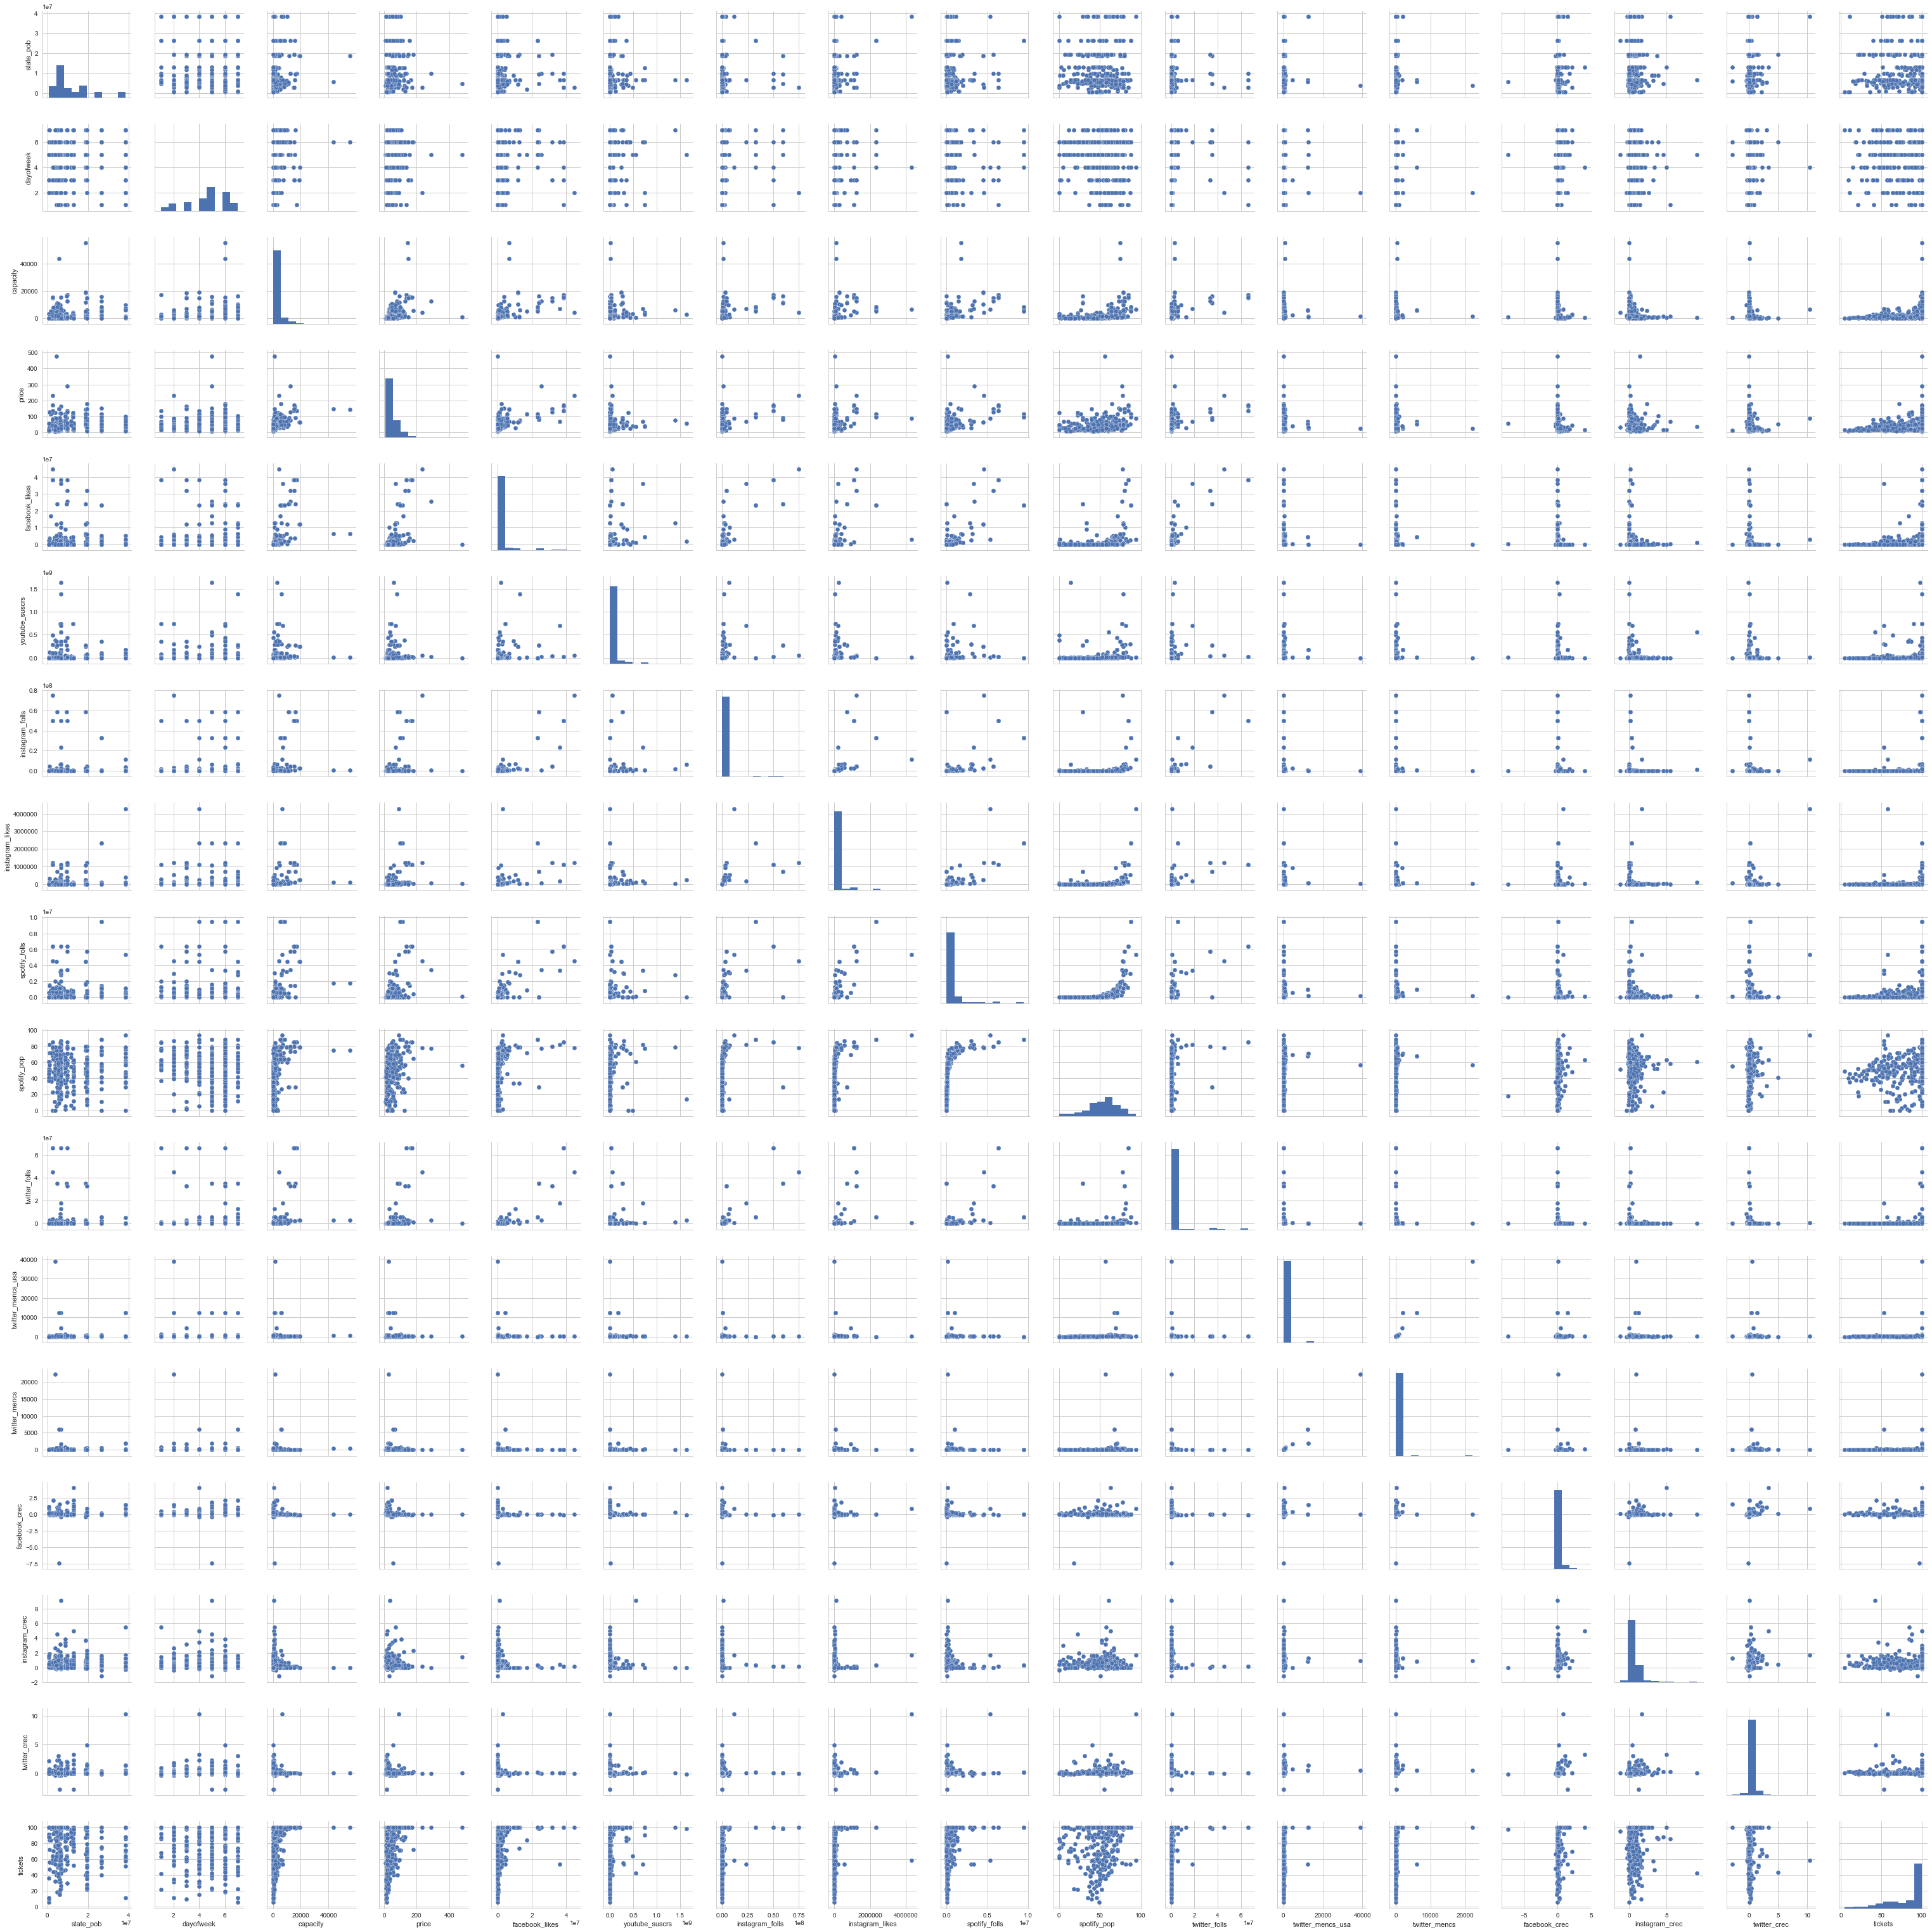

In [1681]:
# grafico de variables

data_df = pd.DataFrame(Xy, columns=['state_pob', 'dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs', 'facebook_crec', 'instagram_crec', 'twitter_crec', 'tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, kind='reg')#, size=2.0);
plt.tight_layout()

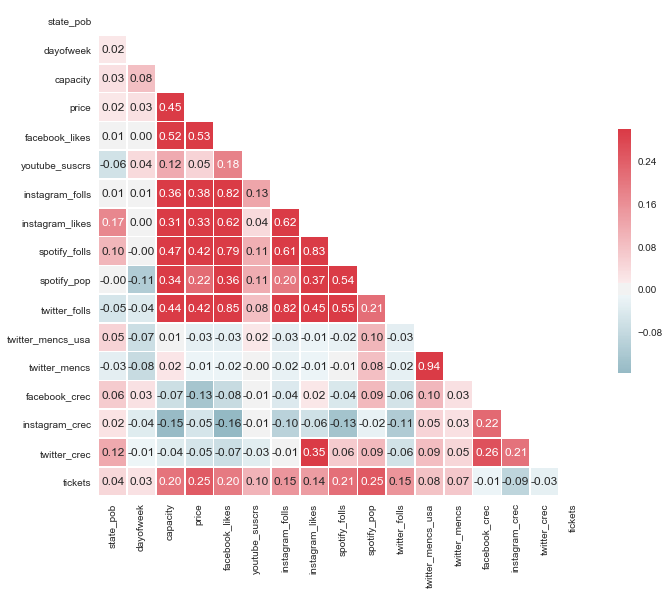

In [1461]:
# correlacion entre variables

corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

En base a la observacion de las variables, se puede apreciar que hay variables que estan poco correlacionadas con la venta de tickets. En particular, esto sucede con: <i>state_pob, dayofweek, twitter_mencs_usa, twitter_mencs, facebook_crec, instagram_crec</i> y <i>twitter_crec</i>, con una correlacion inferior al 10%.

# Modelo de regresion

A continuación se realiza el entrenamiento del modelo. Luego de probar con diversos algoritmos, se decidió utilizar <I>RandomForestRegressor</I>.

Para medir la efectividad del proceso, se implementó una medida del resultado considerando una categorización en clases de los datos y la prediccion, considerando un umbral para el valor de la variable dependiente. En este caso, se determinó que los valores mayores o iguales a 77% serían considerados un <b>resultado positivo</b>, y valores menores, un <b>resultado negativo</b>.

De esta manera, el sistema realiza el conteo de casos satisfactoriamente predichos, entregando un score de <B><I>accuracy</I></B>. Tambien se calculan los valores de R^2 (coeficiente de determinacion) y RMSE (raiz del error cuadratico medio).

In [1723]:
# implementacion modelo, utilizando validacion cruzada

model = models[algorithm]

X=np.array(X)
predictions = []
r2s = []
rmses = []

all_aciertos_positivo = 0; all_aciertos_negativo = 0
all_errores_positivo = 0; all_errores_negativo = 0

kf = KFold(n_splits=10,shuffle=True)
for k, (train, test) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train,:], X[test,:]
    y_train, y_test = y[train], y[test]
    model = models['randomforest']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = y_pred.copy()
    
    measures.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    y_list = list(y_test)
    for k in range(0, len(predictions)):
        #print str(y_list[k]) + ' :',
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
            
        if y_list[k] >= threshold: sum_positivo += 1
        else: sum_negativo += 1
        if predictions[k] >= threshold: sum_predict_positivo += 1
        else: sum_predict_negativo += 1

    all_aciertos_positivo += aciertos_positivo
    all_aciertos_negativo += aciertos_negativo
    all_errores_positivo  += errores_positivo
    all_errores_negativo  += errores_negativo

    r2s.append(r2_score(y_list, predictions))
    rmses.append(np.sqrt(mean_squared_error(predictions, y_list)))
    
    print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
    print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
    print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    df = pd.DataFrame({'real': y_list, 'prediction': predictions})    

print
print "R2s: ", np.mean(r2s)
print "RMSEs: ",np.mean(rmses)
print "scores: ", np.mean(scores)

print
conf = pd.DataFrame([[all_aciertos_positivo, all_errores_positivo], [all_errores_negativo, all_aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.03, RMSE: 22.66, SCORE: 26 / 36 = 0.722
R2: -0.1, RMSE: 25.1, SCORE: 20 / 36 = 0.556
R2: 0.19, RMSE: 22.05, SCORE: 29 / 36 = 0.806
R2: -0.16, RMSE: 22.29, SCORE: 23 / 36 = 0.639
R2: -0.05, RMSE: 21.1, SCORE: 21 / 36 = 0.583
R2: 0.07, RMSE: 25.55, SCORE: 24 / 36 = 0.667
R2: 0.2, RMSE: 22.13, SCORE: 25 / 36 = 0.694
R2: -0.15, RMSE: 23.93, SCORE: 20 / 36 = 0.556
R2: 0.02, RMSE: 23.89, SCORE: 23 / 36 = 0.639
R2: 0.34, RMSE: 19.6, SCORE: 25 / 36 = 0.694

R2s:  0.03944301309366936
RMSEs:  22.830236837715614
scores:  0.6695



,positivo,negativo
positivo,167,68
negativo,56,69


Respecto a la predicción, se grafica su resultado, donde se muestran los valores reales versus las predicciones. En este gráfico se puede apreciar que el cuadrante superior-derecha muestra los casos positivos correctamente clasificados, lo mismo con el cuadrante inferior-izquierda, para los casos negativos. El resto de los casos son los erroneamente clasificados.

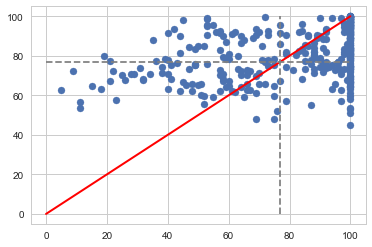

In [1725]:
# grafico de dispersion de las predicciones

plt.scatter(y_list_all, predictions_all)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

# Recursive Feature Elimination

A continuacion, se prueba la eliminacion recursiva de caracteristicas, para construir un modelo con menos variables.

In [1726]:
# inicializacion y ejecucion del modelo

from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
Xdf = pd.DataFrame(X)
print list(Xdf.columns.values)[:62]
print rfe.support_
y_pred = rfe.predict(X_test)

[0, 1, 2, 3, 4, 5, 6]
[ True  True  True  True  True  True  True]


In [1685]:
# calculo de errores y aciertos

sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
errores_positivo = 0; errores_negativo = 0
sum_positivo = 0; sum_negativo = 0
sum_predict_positivo = 0; sum_predict_negativo = 0
total_test = len(X_test)

y_list = list(y_test)
for k in range(0, len(y_pred)):
    sum += abs(y_pred[k] - y_list[k])
    if y_list2[k] >= threshold and y_pred[k] >= threshold:
        aciertos_positivo += 1
    if y_list2[k] >= threshold and y_pred[k] < threshold:
        errores_positivo += 1
    if y_list2[k] < threshold and y_pred[k] < threshold:
        aciertos_negativo += 1
    if y_list2[k] < threshold and y_pred[k] >= threshold:
        errores_negativo += 1
    if y_list2[k] >= threshold:
        sum_positivo += 1
    else:
        sum_negativo += 1
    if y_pred[k] >= threshold:
        sum_predict_positivo += 1
    else:
        sum_predict_negativo += 1

In [1686]:
# estadisticas del modelo

print
print "R2: " + str(round(r2_score(y_test, y_pred), 2))
print "RMSE: " + str(round(np.sqrt(mean_squared_error(y_pred, y_test)), 2))
print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
df = pd.DataFrame({'real': y_test, 'prediction': y_pred})
print "correlacion: " + str(round(df.corr()['real'][0], 2))
print "confusion-matrix:"
conf = pd.DataFrame([[aciertos_positivo, errores_positivo], [errores_negativo, aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: -0.01
RMSE: 26.69
SCORE: 39 / 72 = 0.542
PRECISION: 0.667
RECALL: 0.596
correlacion: 0.21
confusion-matrix:


,positivo,negativo
positivo,28,19
negativo,14,11


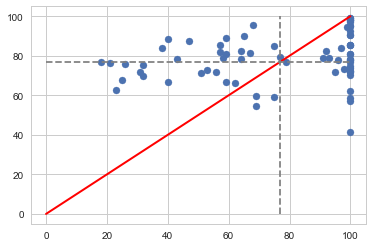

In [1687]:
# grafico de dispersion de las predicciones

plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

# Pruebas con algunas variables

En base al analisis de variables realizado, se determina que se eliminaran las siguientes variables:
- state_pob
- dayofweek
- youtube_suscrs
- twitter_mencs_usa
- twitter_mencs
- facebook_crec
- instagram_crec
- twitter_crec

Ahora, el dataset es mas reducido, y se procede a entrenar un nuevo modelo para ver sus resultados.

In [1713]:
# nuevo armado del conjunto de variables

mapper = sp.DataFrameMapper([
    #('dayofweek', LabelBinarizer()),
    (['capacity', 'facebook_likes',# 'youtube_suscrs', 
    'instagram_folls', 'instagram_likes',
    'spotify_folls',
    'spotify_pop',
    'twitter_folls'
    #,'facebook_crec', 'instagram_crec', 'twitter_crec'
    ], StandardScaler())
    ])
#X = dataset[['capacity', 'price',
X = dataset[['capacity', 
        'facebook_likes',# 'youtube_suscrs', 
        'instagram_folls', 'instagram_likes',
        'spotify_folls',
        'spotify_pop',
        'twitter_folls'
    #,'facebook_crec', 'instagram_crec', 'twitter_crec'
    ]]
X = mapper.fit_transform(X)
y = dataset['tickets']

# Pruebas de algoritmos, con conjunto de test

Se separa el dataset en dos conjuntos: training y test.

knn
	R2: -0.06
	RMSE: 24.1
	SCORE: 91 / 144 = 0.632


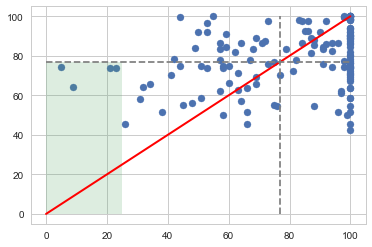

gradient
	R2: -0.05
	RMSE: 23.88
	SCORE: 94 / 144 = 0.653


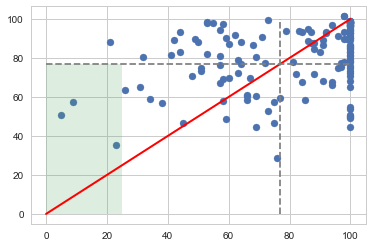

randomforest
	R2: 0.03
	RMSE: 22.98
	SCORE: 91 / 144 = 0.632


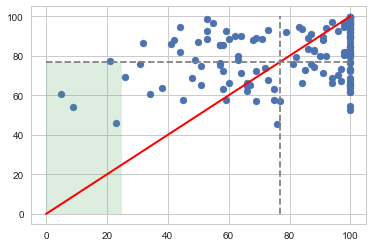

adaboost
	R2: -0.03
	RMSE: 23.64
	SCORE: 87 / 144 = 0.604


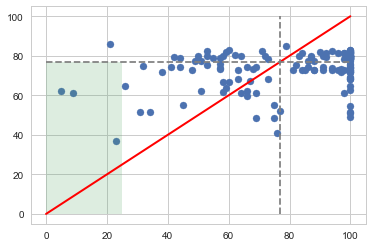

In [1824]:
# probando diferentes algoritmos de regresion

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

models = {}
models['knn']          = KNeighborsRegressor()
models['randomforest'] = RandomForestRegressor(n_estimators=400, criterion='mse', max_depth=None, min_samples_split=1, min_samples_leaf=1, max_features='auto', bootstrap=True, oob_score=True, n_jobs=4, random_state=None, verbose=0)
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor(loss='huber', criterion='mse')
#{‘ls’, ‘lad’, ‘huber’, ‘quantile’}

for algorithm in models:
    print algorithm
    model = models[algorithm]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    #total_test = len(X)
    y_list = list(y_test)

    for k in range(0, len(predictions)):
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
        if y_list[k] >= threshold:
            sum_positivo += 1
        else:
            sum_negativo += 1
        if predictions[k] >= threshold:
            sum_predict_positivo += 1
        else:
            sum_predict_negativo += 1

    print "\tR2: " + str(round(r2_score(y_list, predictions), 2))
    print "\tRMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2))
    print "\tSCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    #conf = pd.DataFrame([[np.sum(aciertos_pos), np.sum(errores_pos)], [np.sum(errores_neg), np.sum(aciertos_neg)]], columns=['positivo', 'negativo'])
    #conf.rename(index={0:'positivo', 1:'negativo'})

    # grafico de dispersion de las predicciones
    plt.scatter(y_list, predictions)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    x0 = [0, 0, 25, 25]
    y0 = [0, threshold, threshold, 0]
    ax.fill(x0, y0, alpha=0.2)
    plt.show()

# Modelo de regresion, con validacion cruzada

Ahora se realiza la validacion utilizando validacion cruzada, con 10 folds.


In [1717]:
# implementacion modelo, utilizando validacion cruzada

model = models[algorithm]
model.fit(X_train, y_train)
#predictions = model.predict(X_test)
#predictions = cross_val_predict(model, X, y, cv=6)

r2s = []
rmses =[]
scores = []
X=np.array(X)
predictions_all = []
aciertos_pos = []; aciertos_neg = []; errores_pos = []; errores_neg = []
sum_ylist = 0; sum_pred = 0
p = 0
yy = []
xx = []
y_list_all = []

kf = KFold(n_splits=10, shuffle=True)
for k, (train, test) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train,:], X[test,:]
    y_train, y_test = y[train], y[test]
    model = models['randomforest']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #predictions.extend(y_pred)
    predictions = y_pred.copy()
    
    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    #total_test = len(X)
    y_list = list(y_test)

    for k in range(0, len(predictions)):
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
        if y_list[k] >= threshold:
            sum_positivo += 1
        else:
            sum_negativo += 1
        if predictions[k] >= threshold:
            sum_predict_positivo += 1
        else:
            sum_predict_negativo += 1

    print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
    print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
    print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    #print "score2: " + str(round(1.0 * aciertos_positivo / sum_positivo * 0.5 + 1.0 * aciertos_negativo / sum_negativo * 0.5, 3))
    #print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
    #print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
    df = pd.DataFrame({'real': y_list, 'prediction': predictions})
    
    aciertos_pos.append(aciertos_positivo)
    aciertos_neg.append(aciertos_negativo)
    errores_pos.append(errores_positivo)
    errores_neg.append(errores_negativo)
    
    r2s.append(r2_score(y_list, predictions))
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    
    predictions_all.extend(predictions)
    y_list_all.extend(y_list)
    
    sum_ylist += np.sum(y_list)
    sum_pred  += np.sum(predictions)
    
    p += 1
    
print
#print ("Resultados modelo: ",measures)
print "R2s: ", np.mean(r2s)
print "RMSEs: ",np.mean(rmses)
print "scores: ", np.mean(scores)
conf = pd.DataFrame([[np.sum(aciertos_pos), np.sum(errores_pos)], [np.sum(errores_neg), np.sum(aciertos_neg)]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})

#pd.DataFrame(xx).to_csv('/home/dgomez/y_list.csv', sep=',')
#pd.DataFrame(yy).to_csv('/home/dgomez/predictions.csv', sep=',')


R2: -0.26, RMSE: 22.85, SCORE: 19 / 36 = 0.528
R2: 0.19, RMSE: 23.5, SCORE: 23 / 36 = 0.639
R2: -0.43, RMSE: 22.5, SCORE: 22 / 36 = 0.611
R2: 0.07, RMSE: 21.38, SCORE: 27 / 36 = 0.75
R2: 0.24, RMSE: 23.01, SCORE: 29 / 36 = 0.806
R2: 0.16, RMSE: 25.26, SCORE: 22 / 36 = 0.611
R2: 0.06, RMSE: 24.61, SCORE: 27 / 36 = 0.75
R2: -0.08, RMSE: 22.34, SCORE: 19 / 36 = 0.528
R2: 0.08, RMSE: 20.69, SCORE: 27 / 36 = 0.75
R2: 0.23, RMSE: 19.42, SCORE: 26 / 36 = 0.722

R2s:  0.025235970405705875
RMSEs:  22.557502538426988
scores:  0.6695


,positivo,negativo
positivo,166,69
negativo,50,75


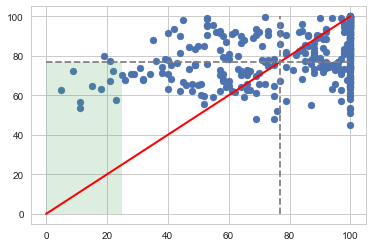

In [1718]:
# grafico de dispersion de las predicciones

plt.scatter(y_list_all, predictions_all)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
x0 = [0, 0, 25, 25]
y0 = [0, threshold, threshold, 0]
ax.fill(x0, y0, alpha=0.2)

In [1504]:
# despliegue como clases

df = pd.DataFrame(y_list_all)
df.columns = ['tickets']
df.insert(loc=1, column='predictions', value=np.round(predictions_all))
y_label = copy.copy(y_list_all)
type(y_label)
for k in range(0, len(y_label)):
    if y_label[k] >= threshold:
        y_label[k] = 'positivo'
    else:
        y_label[k] = 'negativo'

predictions_label = pd.Series(predictions_all)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1[0].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,100,81.0,positivo,positivo
1,72,84.0,negativo,positivo
2,18,69.0,negativo,negativo
3,79,63.0,positivo,negativo
4,92,84.0,positivo,positivo
